In [ ]:
# ML_in_Finance-PCA-SP500
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., I. Halperin and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

# Overview

The purpose of this notebook is to demonstrate the application of PCA, as a method of dimensionality reduction, to time series of adjusted close prices of SP500 listed assets. The analysis assumes that the prices are weakly covariance stationarity and uses the principal components to explain price variance. The components are also compared with the SP500 index price and index prices are regressed on the components to observe their importance.

In [36]:
from plotly.graph_objs import *
import plotly.tools as tls
import plotly.plotly as py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = 16,10
%matplotlib inline

In [5]:
SP500 = pd.read_csv('../data/SP500.csv', index_col='Date').dropna(axis = 1)
SP500Index = pd.read_csv('../data/^GSPC.csv', index_col='Date')['Close'][:len(SP500)]
SP500moves = SP500.pct_change().dropna()
names = SP500moves.columns.values

Standardize the adjusted close prices of assets in the SP500

In [7]:
SP500norm = (SP500 - SP500.mean())/SP500.std()

Estimate the variance of the standardized asset prices and compute the eigenvalues and eigenvectors

In [14]:
cov = SP500norm.cov()
eig_vals, eig_vecs = np.linalg.eig(cov)
eig_vals = np.real(eig_vals)
eig_vecs = np.real(eig_vecs)

Plot the cumulative explain variance against increasing PCs

In [15]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

trace1 = Bar(
        x=['PC %s' %i for i in range(1,100)],
        y=var_exp,
        showlegend=False)

trace2 = Scatter(
        x=['PC %s' %i for i in range(1,100)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = Data([trace1, trace2])

layout=Layout(
        yaxis=YAxis(title='Explained variance in percent'),
        title='Explained variance by different principal components')

fig = Figure(data=data, layout=layout)
py.iplot(fig)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




Visualize the first ten principle components (PCs) over time and compare with the standardized SP500 index price series

In [16]:
PCs = np.matmul(SP500norm.values, eig_vecs)
PCs = pd.DataFrame(PCs, index=SP500norm.index)
PCs['SP500'] = (SP500Index - SP500Index.mean())/SP500Index.std()

Text(0,0.5,'Normalised Values')

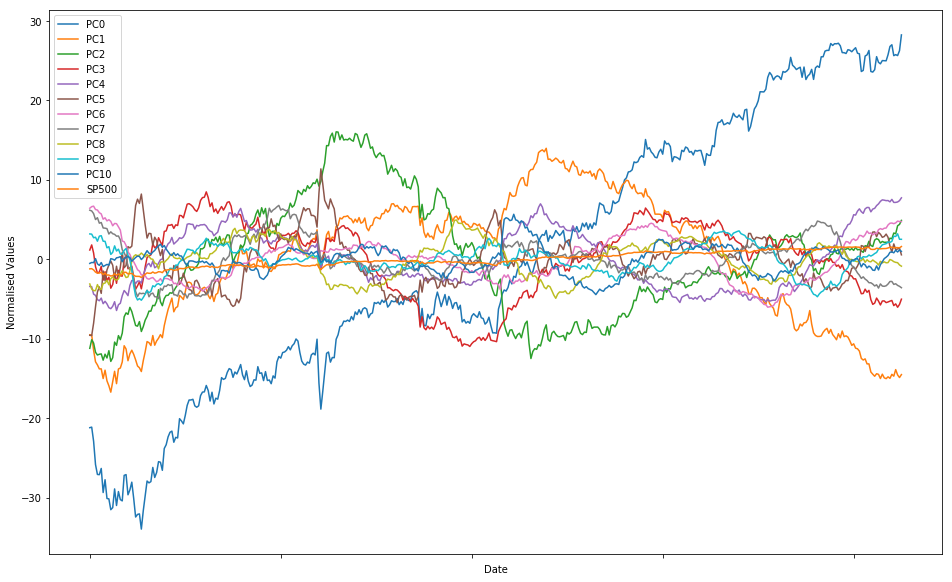

In [17]:
colnames = ['PC'+str(i) for i in np.arange(len(PCs.columns.values)-1)] + ['SP500']
PCs.columns = colnames
PC10 = PCs[['PC0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','SP500']]
PC10.plot()
plt.ylabel('Normalised Values')

# Regress stock index prices on PCs
Regress the standardized SP500 index prices on the PCs to determine the importance of each component.

In [34]:
Y = PCs['SP500']
X = PCs[['PC0','PC1','PC2','PC3','PC4','PC5','PC6','PC7', 'PC8','PC9']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SP500   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.990e+04
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        18:20:08   Log-Likelihood:                 859.22
No. Observations:                 426   AIC:                            -1696.
Df Residuals:                     415   BIC:                            -1652.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.299e-15      0.002  -2.09e-12      1.000      -0.003       0.003
PC0            0.0591   9.38e-05    629.335      0.000       0.059       0.059
PC1            0.0076      0.000     38.078      0.000       0.007       0.008
PC2            0.0025      0.000     11.555      0.000       0.002       0.003
PC3            0.0072      0.000     21.459      0.000       0.007       0.008
PC4            0.0027      0.000      6.429      0.000       0.002       0.004
PC5           -0.0109      0.001    -21.312      0.000      -0.012      -0.010
PC6            0.0068      0.001     11.770      0.000       0.006       0.008
PC7           -0.0080      0.001    -13.528      0.000      -0.009      -0.007
PC8           -0.0039      0.001     -5.678      0.000      -0.005      -0.003
PC9            0.0049      0.001      5.572      0.000       0.003       0.007
==============================================================================
Omnibus:                        6.328   Durbin-Watson:                   0.380
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                4.421
Skew:                           0.102   Prob(JB):                        0.110
Kurtosis:                       2.545   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""